In [1]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib

In [2]:
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.ticker import StrMethodFormatter

In [ ]:
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/Lab 4 data"
all_files_AV = glob.glob(os.path.join(folder, '*.csv'))
AV_li = {}
for filename in all_files_AV:
  date = int(filename.split(sep=".")[2][0:2])
  if date == 13:
    setn = 'Set A'
  elif date == 19:
    setn = 'Set B'
  subn = int(filename.split(sep='-')[1].split(sep='.')[0])
  print(subn)
  if subn >= 16 or subn == 9:
    id = "All three sprayed"
  elif 11 <= subn <= 15:
    id = "Sprayed Perovskite and SpiroOMeTAD"
  elif (6 <= subn <= 10) and ((subn%2) == 0):
    id = "Sprayed SnO2 and Perovskite"
  elif subn < 6:
    id = "None sprayed"
  print(id)
  name = id + " -- " + setn + "-" + str(subn)


  #isolates name from file and drops last 3 rows
  AV_li[name] = pd.read_csv(filename, sep = ',' , header = 1, nrows = 140, index_col='V', usecols=['V','mA/cm^2.1', 'mA/cm^2.2', 'mA/cm^2.3', 'mA/cm^2.4'])


Mounted at drive
1
None sprayed
2
None sprayed
3
None sprayed
4
None sprayed
5
None sprayed
6
Sprayed SnO2 and Perovskite
8
Sprayed SnO2 and Perovskite
9
All three sprayed
10
Sprayed SnO2 and Perovskite
11
Sprayed Perovskite and SpiroOMeTAD
12
Sprayed Perovskite and SpiroOMeTAD
13
Sprayed Perovskite and SpiroOMeTAD
14
Sprayed Perovskite and SpiroOMeTAD
15
Sprayed Perovskite and SpiroOMeTAD
16
All three sprayed
17
All three sprayed
18
All three sprayed
20
All three sprayed
1
None sprayed
2
None sprayed
3
None sprayed
4
None sprayed
5
None sprayed
6
Sprayed SnO2 and Perovskite
7
Sprayed SnO2 and Perovskite
8
Sprayed SnO2 and Perovskite
9
All three sprayed
10
Sprayed SnO2 and Perovskite
11
Sprayed Perovskite and SpiroOMeTAD
12
Sprayed Perovskite and SpiroOMeTAD
13
Sprayed Perovskite and SpiroOMeTAD
14
Sprayed Perovskite and SpiroOMeTAD
15
Sprayed Perovskite and SpiroOMeTAD
16
All three sprayed
17
All three sprayed
18
All three sprayed
19
All three sprayed


In [ ]:
#splitting up data into forward and backwards runs
def data_split(input_data):
  df= input_data
  df1=pd.DataFrame()
  df2=pd.DataFrame()
  for j in range(1, 5):
    df1["Pixel " + str(j)+ " (Forward)"] = df['mA/cm^2.'+str(j)].head(n=int(np.floor(len(df.index)/2)+1))
    df2["Pixel " + str(j)+ " (Reverse)"] = df.tail(n=(int(np.floor(len(df.index)/2)-1)))['mA/cm^2.'+str(j)]
  frame = df1.merge(df2, how='left', left_index=True, right_index=True)
  frame = frame.dropna()
  return frame

split_li = {}
for name in AV_li:
  split_li[name] = data_split(AV_li[name])
split_li
    

{'All three sprayed -- Set A-16':        Pixel 1 (Forward)  ...  Pixel 4 (Reverse)
 V                         ...                   
 -0.16           -22.5459  ...           -21.8675
 -0.14           -22.3863  ...           -21.9074
 -0.12           -22.3863  ...           -21.8276
 -0.10           -22.4262  ...           -21.8675
 -0.08           -22.4661  ...           -21.8675
 ...                  ...  ...                ...
  1.12            21.6680  ...            13.3280
  1.14            27.4541  ...            23.1045
  1.16            33.7590  ...            33.9585
  1.18            40.9417  ...            46.2889
  1.20            48.8029  ...            59.2578
 
 [69 rows x 8 columns],
 'All three sprayed -- Set A-17':        Pixel 1 (Forward)  ...  Pixel 4 (Reverse)
 V                         ...                   
 -0.16           -21.9473  ...          -22.50600
 -0.14           -21.9473  ...          -22.50600
 -0.12           -21.9074  ...          -22.50600
 -0.10  

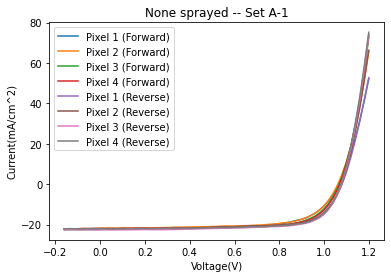

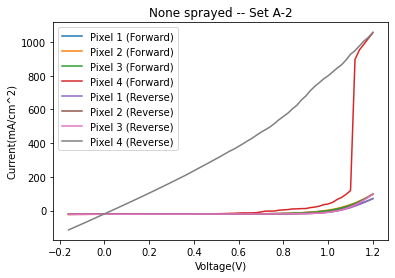

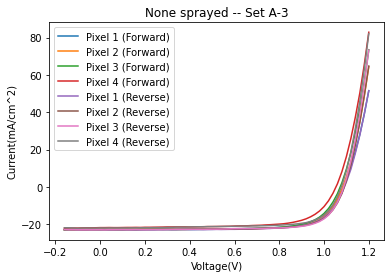

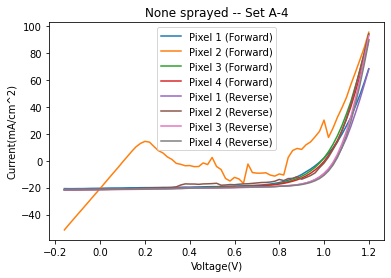

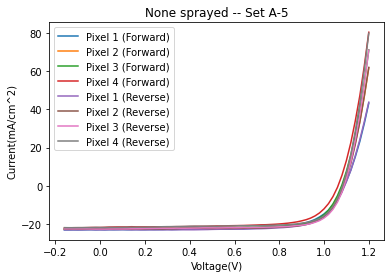

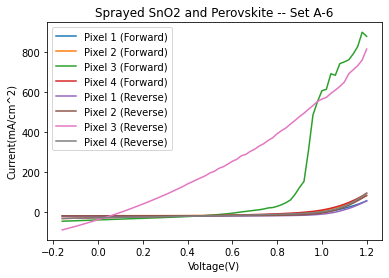

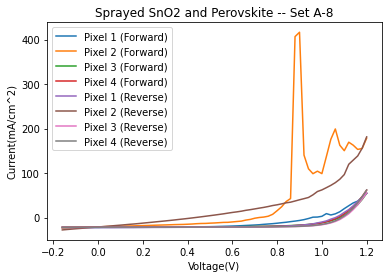

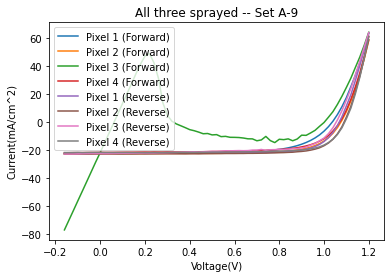

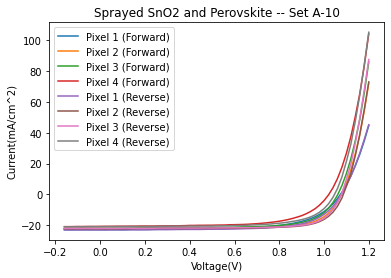

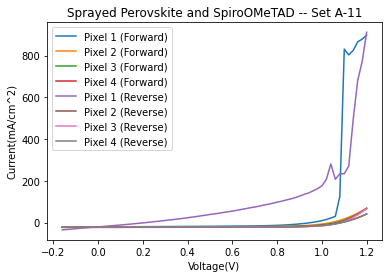

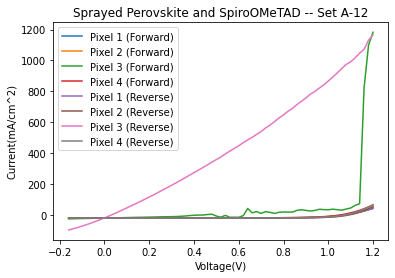

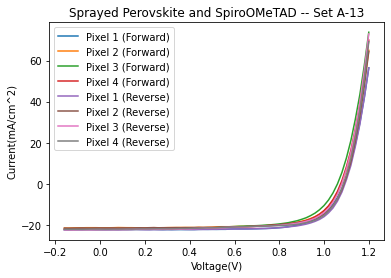

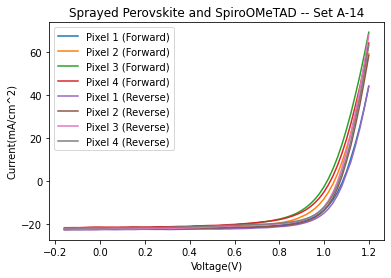

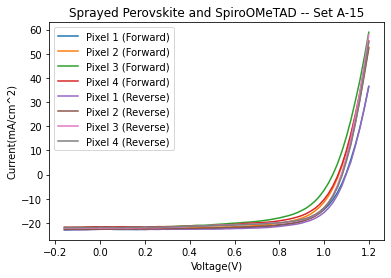

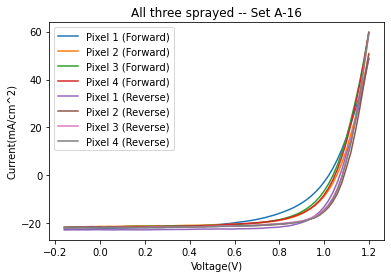

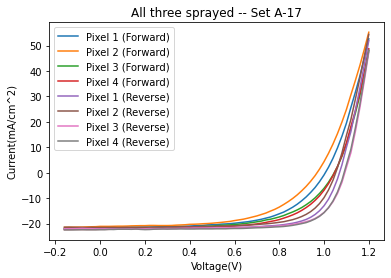

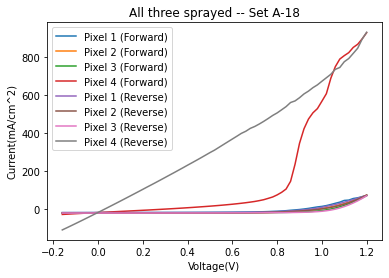

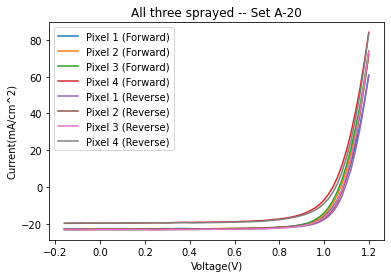

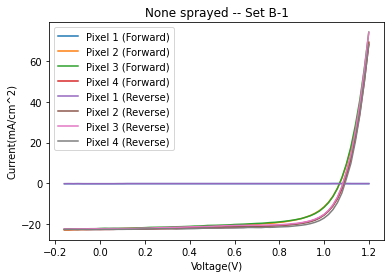

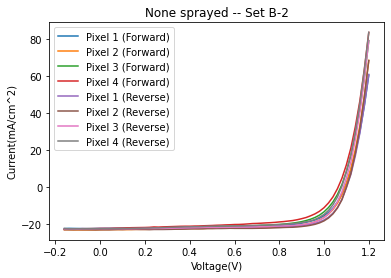

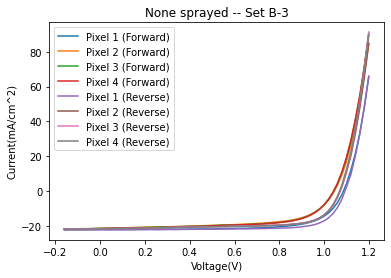

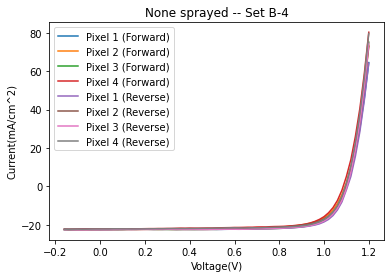

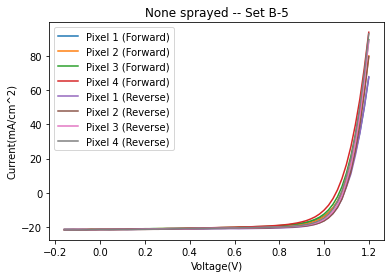

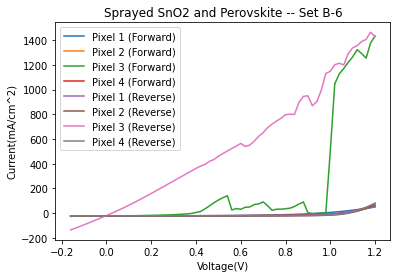

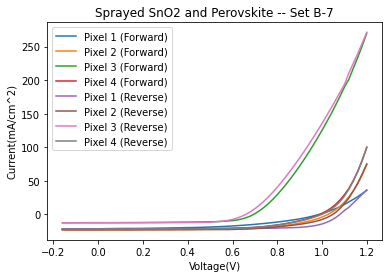

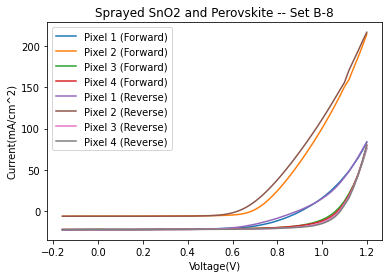

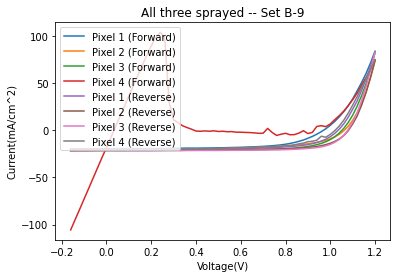

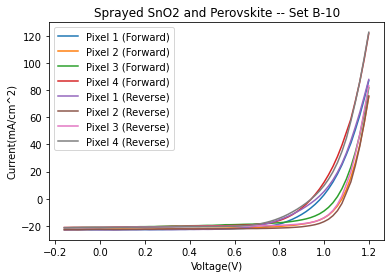

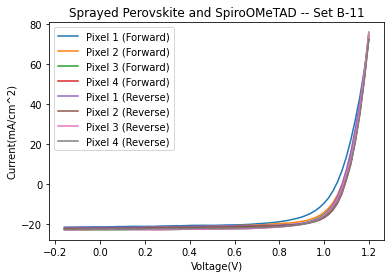

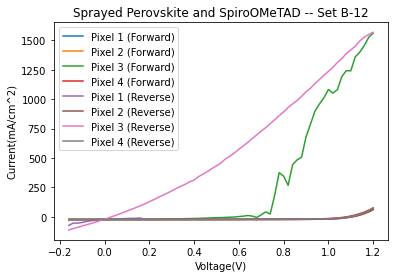

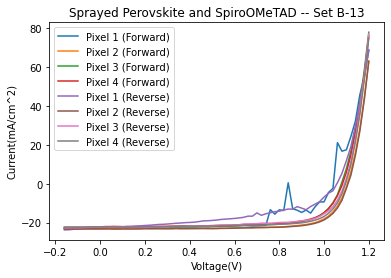

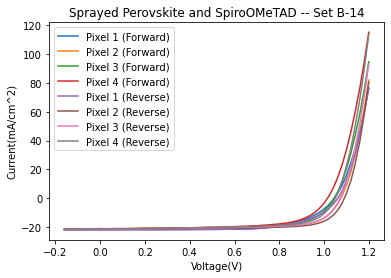

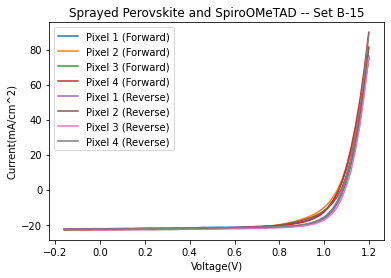

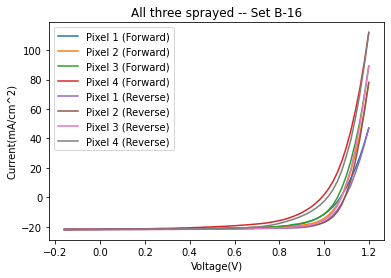

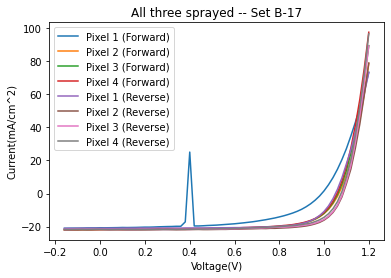

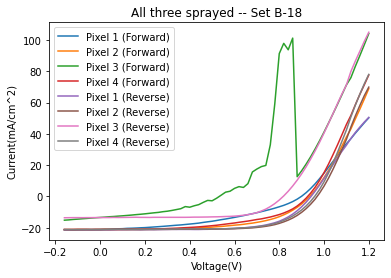

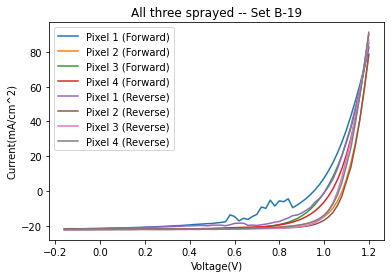

In [ ]:
def plot_JVs(input_data):
  x = np.asarray(input_data.index)
  for j in range(len(input_data.columns)):
    col = input_data.columns[j]
    y=np.asarray(input_data[col])
    plt.plot(x, y, label = col)



for name in AV_li:
  plot_JVs(data_split(AV_li[name]))
  plt.title(name)
  plt.xlabel("Voltage(V)")
  plt.ylabel("Current(mA/cm^2)")
  plt.legend()
  plt.show()

In [ ]:
def get_vals(input_data, num):
  x=np.asarray(input_data.index)
  y=np.asarray(input_data[input_data.columns[num]])
  #creates spline cubic interpolation function
  f = interp1d(x, y, 'cubic')
  #get zeroes from interpolation 
  Jsc = float(f(0))
 
  if len(scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots()) == 0:
    Voc = np.nan
  else:
     Voc = scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots().astype(float)[0]
  #plot x*y vs x to get P vs V
  PvsVdata = pd.DataFrame(np.stack((x, x*y), axis =-1), columns=('Voltage(V)', 'Power(W)'))
  #other relevant quantities
  Pmax = min(PvsVdata['Power(W)'])
  FF = Pmax /(Jsc*Voc)
  #Irradiance from spectral data
  Ispec = 99.1
  PCE = -Pmax / (Ispec) * 100
  return {'Test':name, 'Pixel': input_data.columns[num], 'Jsc (mA/cm^2)':Jsc, 'Voc (V)':Voc, 'Pmax (mW/cm^2)':Pmax, 'FF':FF , 'PCE(%)':PCE}


In [ ]:
#Assemble data
df = pd.DataFrame(columns = ['Test','Pixel', 'Jsc (mA/cm^2)', 'Voc (V)', 'Pmax (mW/cm^2)', 'FF', 'PCE(%)'])
nf = pd.DataFrame(columns = ['Test', 'Pixel', 'Reason'])

for name in split_li:
  for i in range(len(split_li[name].columns)):
    df = df.append(get_vals(split_li[name], i), ignore_index =True)
#came back later to create dataframe for values left out to create table
#stats
  for pixel in df[df['Test']==name]['Pixel']:
    if split_li[name][pixel][1.2] > 150:
      nf = nf.append({'Test':name,'Pixel':pixel, 'Reason':'J at 1.2V = '+str(np.around(split_li[name][pixel][1.2], decimals=2))+' mA/cm^2'}, ignore_index=True)
print(df['Jsc (mA/cm^2)'].mean())
print(df['Jsc (mA/cm^2)'].std())
for i in range(len(df.index)):
  if df.iloc[i]['PCE(%)'] <= 3:
    nf = nf.append({'Test': df.iloc[i]['Test'], 'Pixel': df.iloc[i]['Pixel'], 'Reason': 'PCE = ' + str(np.around(df.iloc[i]['PCE(%)'], decimals=2))+'%'}, ignore_index=True)
  elif df.iloc[i]['FF'] >= 1:
     nf = nf.append({'Test': df.iloc[i]['Test'], 'Pixel': df.iloc[i]['Pixel'], 'Reason': 'Fill Factor = ' + str(np.around(df.iloc[i]['FF'], decimals=2))}, ignore_index=True)
  elif (df.iloc[i]['Jsc (mA/cm^2)'] < -28) or (df.iloc[i]['Jsc (mA/cm^2)'] > -15):
    nf = nf.append({'Test': df.iloc[i]['Test'], 'Pixel': df.iloc[i]['Pixel'], 'Reason': 'Jsc = ' + str(np.around(df.iloc[i]['Jsc (mA/cm^2)'], decimals=2))+' mA/cm^2'}, ignore_index=True)
  elif pd.isna(df.iloc[i]['Voc (V)']):
    nf = nf.append({'Test': df.iloc[i]['Test'], 'Pixel': df.iloc[i]['Pixel'], 'Reason': 'Unstable Voc'}, ignore_index=True)
nf = nf.set_index('Test')

print(nf.to_string())
print(len(nf))


-21.711406222972975
3.0510944086321725
                                                            Pixel                       Reason
Test                                                                                          
None sprayed -- Set A-2                         Pixel 4 (Forward)  J at 1.2V = 1055.87 mA/cm^2
None sprayed -- Set A-2                         Pixel 4 (Reverse)  J at 1.2V = 1058.74 mA/cm^2
Sprayed SnO2 and Perovskite -- Set A-6          Pixel 3 (Forward)   J at 1.2V = 880.01 mA/cm^2
Sprayed SnO2 and Perovskite -- Set A-6          Pixel 3 (Reverse)    J at 1.2V = 816.2 mA/cm^2
Sprayed SnO2 and Perovskite -- Set A-8          Pixel 2 (Forward)   J at 1.2V = 178.45 mA/cm^2
Sprayed SnO2 and Perovskite -- Set A-8          Pixel 2 (Reverse)   J at 1.2V = 181.36 mA/cm^2
Sprayed Perovskite and SpiroOMeTAD -- Set A-11  Pixel 1 (Forward)   J at 1.2V = 898.08 mA/cm^2
Sprayed Perovskite and SpiroOMeTAD -- Set A-11  Pixel 1 (Reverse)   J at 1.2V = 911.53 mA/cm^2
Sprayed Per

In [ ]:
#creating dataframes to support overall conclusions per group

groups = ['None', 'SnO2 and Perovskite', 'Perovskite and SpiroOMeTAD', 'All three']
quantities = df.columns[2:]
summary = pd.DataFrame(columns=quantities, index=groups)
for group in groups:
  for quantity in quantities:
    qmean = np.around(df[df.Test.str.contains(group,case=False)][quantity].mean(), 2)
    qdev = np.around(df[df.Test.str.contains(group,case=False)][quantity].std(), 2)
    qstr = "    " + str(qmean) + ' (+/- ' + str(qdev) + ")    "
    summary.loc[group, quantity] = qstr

summary







,Jsc (mA/cm^2),Voc (V),Pmax (mW/cm^2),FF,PCE(%)
None,-21.47 (+/- 3.48),1.04 (+/- 0.16),-16.19 (+/- 3.71),0.76 (+/- 0.49),16.34 (+/- 3.74)
SnO2 and Perovskite,-21.95 (+/- 5.26),0.94 (+/- 0.24),-13.12 (+/- 4.86),0.62 (+/- 0.14),13.24 (+/- 4.91)
Perovskite and SpiroOMeTAD,-22.09 (+/- 0.64),1.02 (+/- 0.21),-16.03 (+/- 3.72),0.69 (+/- 0.11),16.18 (+/- 3.76)
All three,-21.4 (+/- 1.62),0.98 (+/- 0.23),-14.87 (+/- 3.91),0.86 (+/- 1.11),15.0 (+/- 3.94)


In [ ]:
def clean(name2):
  return str(np.around(data[name][name2].mean(), 2) + " +- " + str(np.around(data[name][name2].std(), 2)


Need new routine for removing dead cells

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


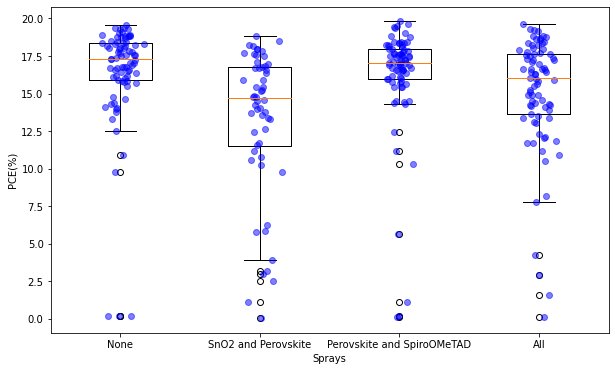

In [ ]:
#Assigning groups to data for boxplot
None_sprayed = np.asarray(df[df.Test.str.contains('None sprayed',case=False)]['PCE(%)'])
SnO2_Perovskite = np.asarray(df[df.Test.str.contains('SnO2',case=False)]['PCE(%)'])
Perovskite_SpiroOMeTAD = np.asarray(df[df.Test.str.contains('SpiroOMeTAD',case=False)]['PCE(%)'])
All_three_sprayed = np.asarray(df[df.Test.str.contains('All three sprayed',case=False)]['PCE(%)'])
data = [None_sprayed, SnO2_Perovskite, Perovskite_SpiroOMeTAD, All_three_sprayed]
plt.figure(figsize=[10,6])
plt.boxplot(data)
plt.xticks(np.arange(1,5), ("None", "SnO2 and Perovskite", "Perovskite and SpiroOMeTAD", "All"))
plt.ylabel('PCE(%)')
plt.xlabel('Sprays')
names = ["None sprayed","Sprayed SnO2 and Perovskite","Sprayed Perovskite and SpiroOMeTAD","All three sprayed"]
#Method from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib, slightly revised
for i in range(1,5):
    y = df[df.Test.str.contains(names[i-1], case=False)]['PCE(%)']
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.06, size=len(y))
    plt.plot(x, y, 'bo', alpha=0.5)

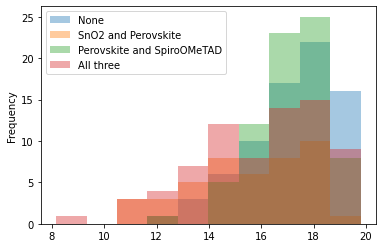

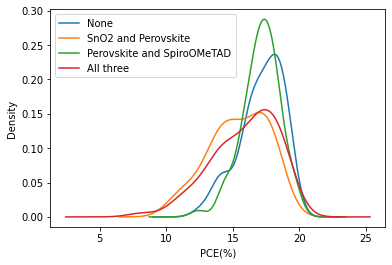

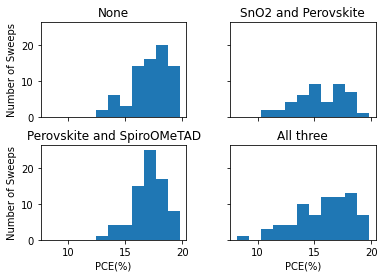

In [ ]:
pcestr = pd.DataFrame([None_sprayed, SnO2_Perovskite,Perovskite_SpiroOMeTAD, All_three_sprayed])
pces = pcestr.transpose()
pces = pces.set_axis(['None', 'SnO2 and Perovskite', 'Perovskite and SpiroOMeTAD', 'All three'], axis = 1, inplace = False)
pces.plot.hist(bins=10, alpha = 0.4)
pces.plot(kind='kde')
plt.xlabel('PCE(%)')
bins=np.histogram(np.hstack((None_sprayed,SnO2_Perovskite,Perovskite_SpiroOMeTAD,All_three_sprayed)), bins=11)[1]
axarr = pces.hist(bins=bins, sharex=True, sharey=True)
for ax in axarr.flatten():
    ax.set_xlabel("PCE(%)")
    ax.set_ylabel("Number of Sweeps")
    ax.grid(False)


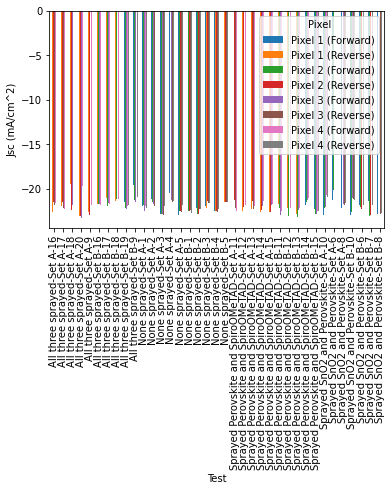

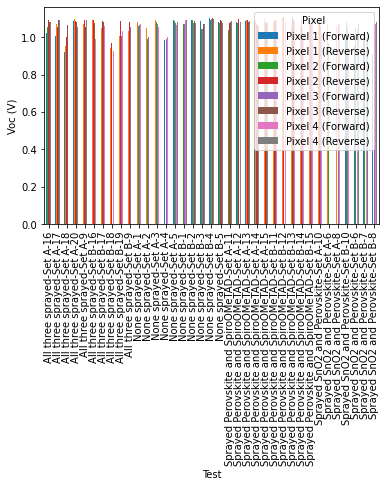

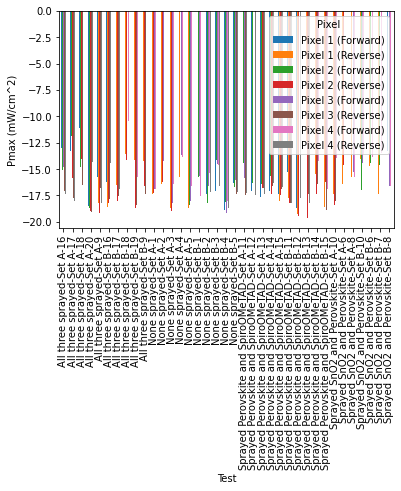

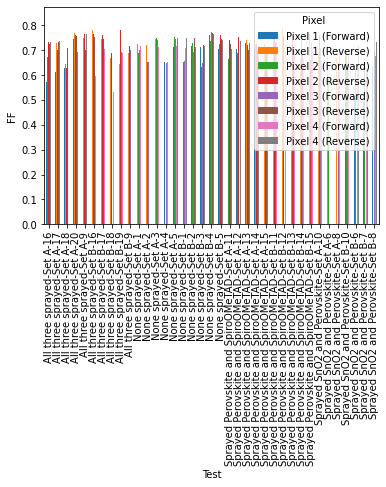

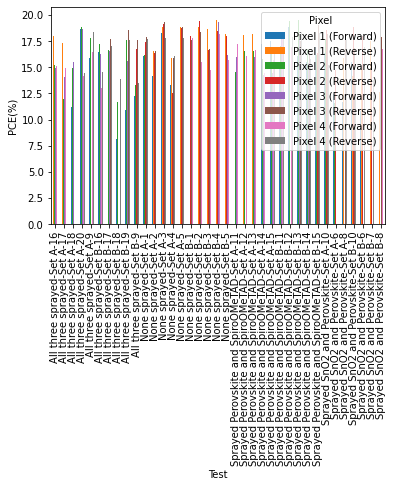

In [ ]:
pcedf = pd.DataFrame({'None':None_sprayed, 'SnO2 and Perovskite':SnO2_Perovskite, 'Perovskite and SpiroOMeTAD':Perovskite_SpiroOMeTAD, 'All three':All_three_sprayed}, orient='index')
pcedf
#Look at each quantity in our data for any outliers
for i in range(5):  
  df.pivot(index='Test', columns='Pixel', values=list(df)[i+2]).plot(kind='bar', ylabel=list(df)[i+2])

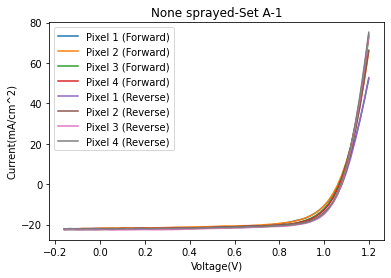

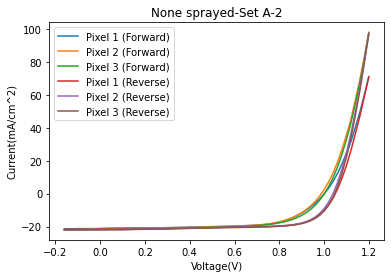

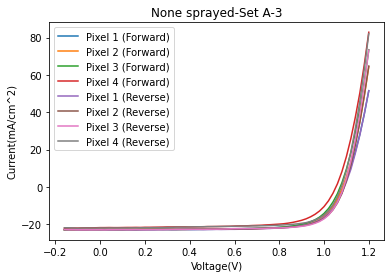

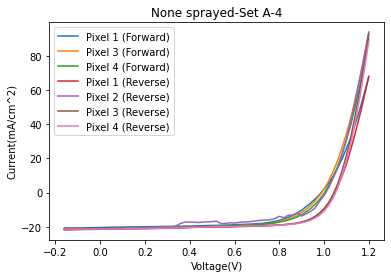

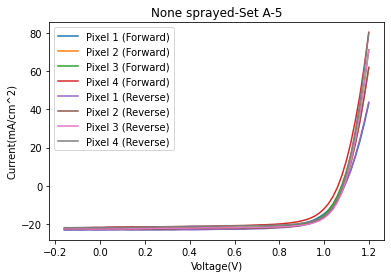

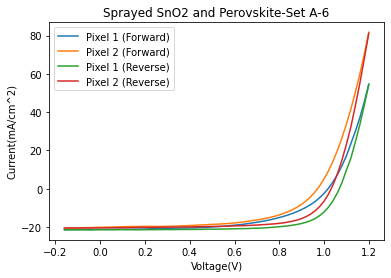

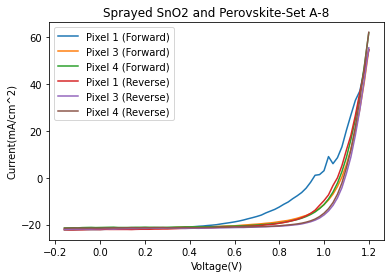

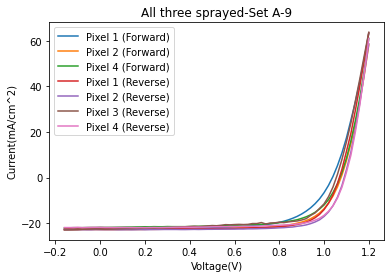

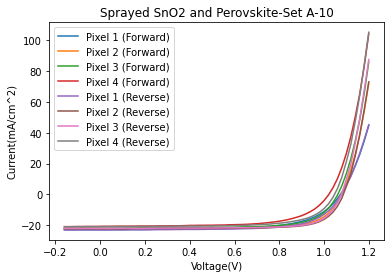

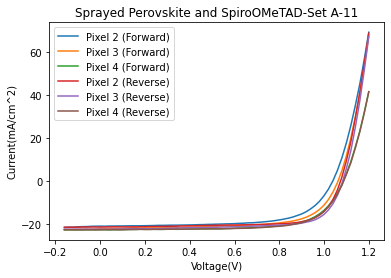

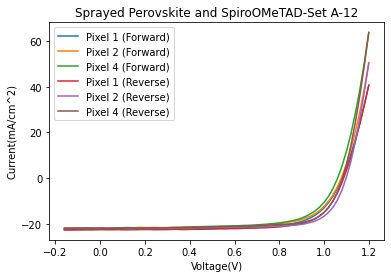

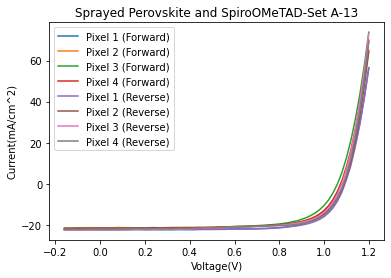

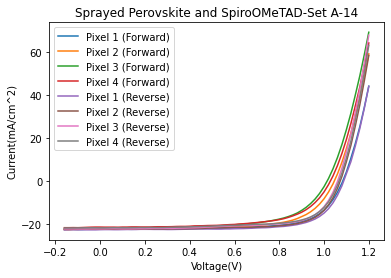

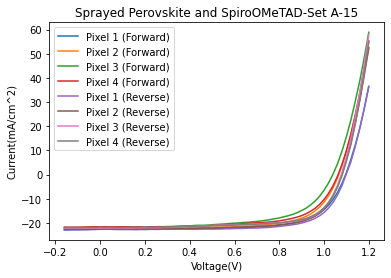

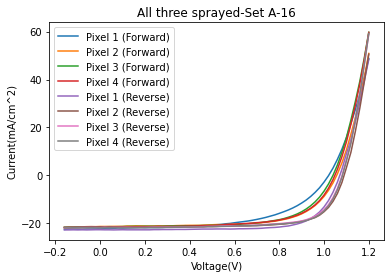

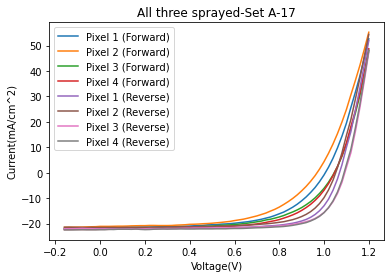

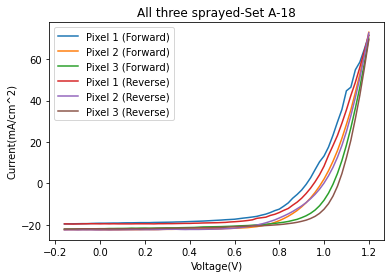

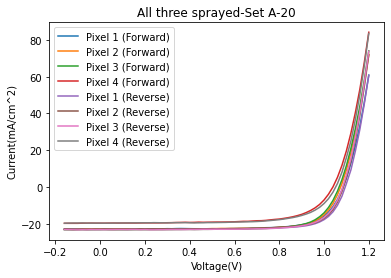

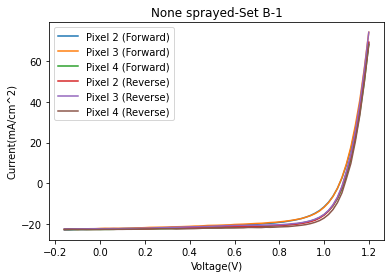

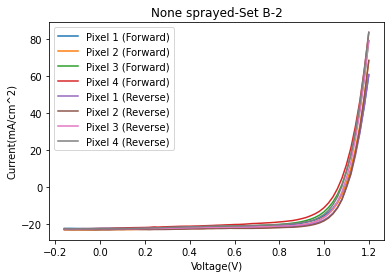

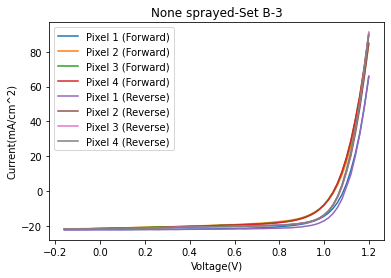

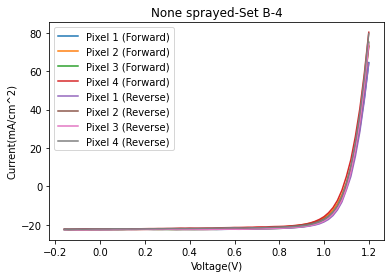

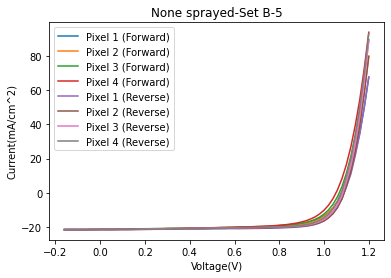

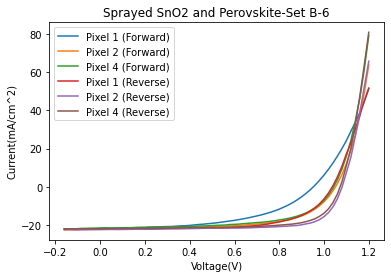

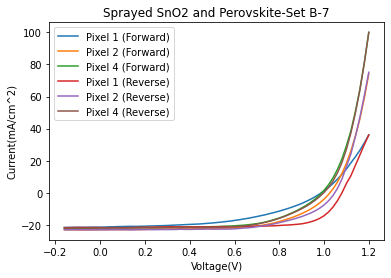

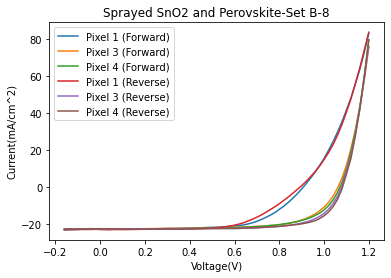

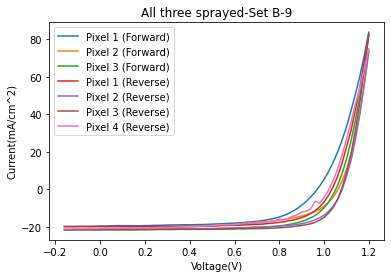

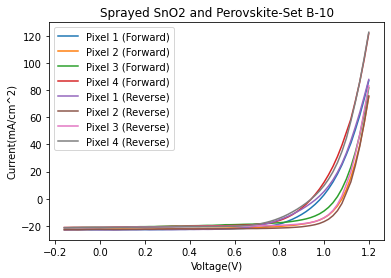

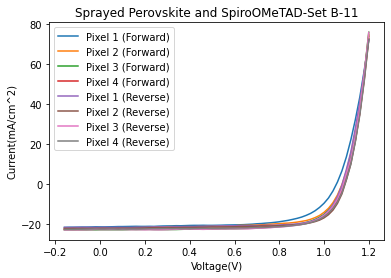

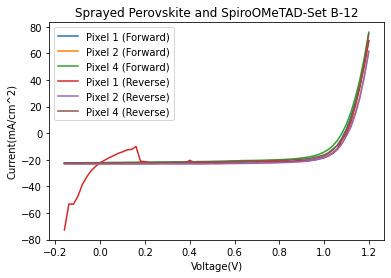

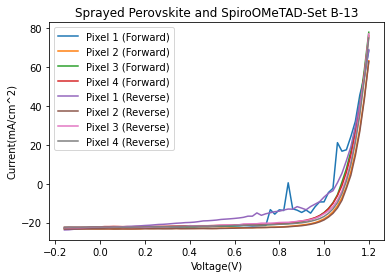

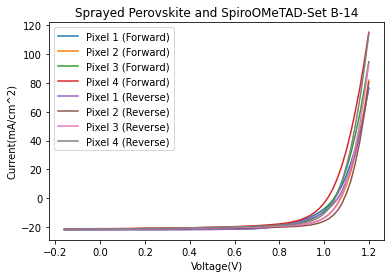

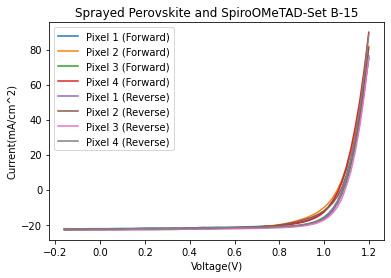

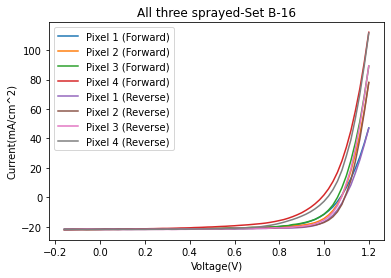

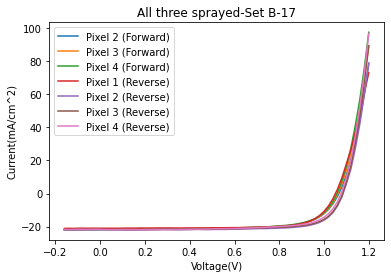

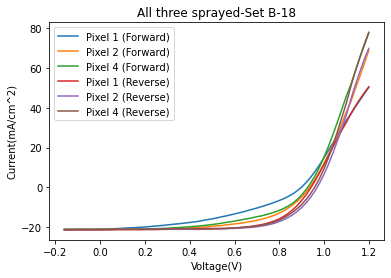

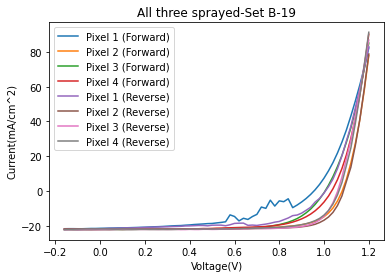

In [ ]:
#check what new JV curves look like
for name in AV_li:
  keep_cols = []
  for pixel in df[df['Test']==name]['Pixel']:
    keep_cols.append(pixel)
  plot_JVs(data_split(AV_li[name])[keep_cols])
  plt.title(name)
  plt.xlabel("Voltage(V)")
  plt.ylabel("Current(mA/cm^2)")
  plt.legend()
  plt.show()